# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os
from keras.saving import register_keras_serializable
import joblib

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


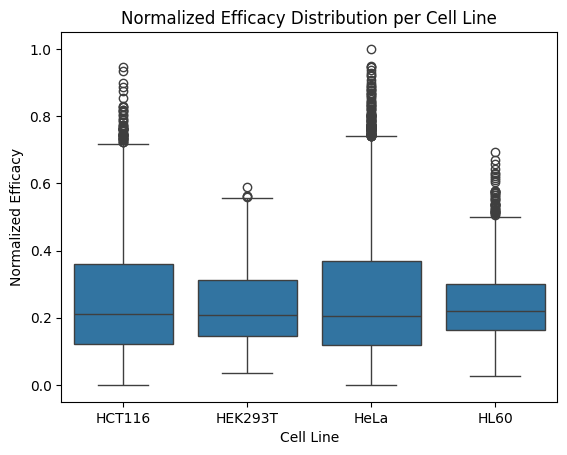

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hl60_df.copy()

In [7]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr3,53916065,53916087,-,GAAGGGCGGCGAGAAGGAGAAGG,0.286080
1,chr3,53916079,53916101,-,GAGAACGGAAAGGAGAAGGGCGG,0.400080
2,chr3,53916094,53916116,-,GAGAAGGGTGATACGGAGAACGG,0.282833
3,chr3,53916119,53916141,-,GTCTCCGGCCATAATGACCCAGG,0.171695
4,chr18,60985747,60985769,+,GGAGGAGAAGATGCCCGGTGCGG,0.429027
...,...,...,...,...,...,...
2071,chr19,54710145,54710167,+,CAACGCCCTGCTGCGGCGGCTGG,0.287346
2072,chr19,54710220,54710242,-,CTAAGAAATCCTCTATCTTCAGG,0.209103
2073,chr19,54710309,54710331,+,TGATCCGCCAGCGCCATATCAGG,0.061508
2074,chr19,54710322,54710344,-,ATCCGAGGTGGTACCTGATATGG,0.181219


In [8]:
df.shape

(2076, 6)

In [9]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 0.693
Min: 0.028
25th percentile (Q1): 0.164
50th percentile (Median): 0.22
75th percentile (Q3): 0.3


In [10]:
df.describe()

,Start,End,Normalized efficacy
count,2.076000e+03,2.076000e+03,2076.000000
mean,6.662495e+07,6.662497e+07,0.232169
std,4.773981e+07,4.773981e+07,0.113508
min,1.015960e+05,1.016180e+05,0.027783
25%,3.438954e+07,3.438956e+07,0.163870
50%,5.469527e+07,5.469529e+07,0.219842
75%,9.903673e+07,9.903675e+07,0.299855
max,2.367674e+08,2.367674e+08,0.692699


In [11]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [12]:
df.info

<bound method DataFrame.info of      Chromosome     Start       End Strand                    sgRNA  \
0          chr3  53916065  53916087      -  GAAGGGCGGCGAGAAGGAGAAGG   
1          chr3  53916079  53916101      -  GAGAACGGAAAGGAGAAGGGCGG   
2          chr3  53916094  53916116      -  GAGAAGGGTGATACGGAGAACGG   
3          chr3  53916119  53916141      -  GTCTCCGGCCATAATGACCCAGG   
4         chr18  60985747  60985769      +  GGAGGAGAAGATGCCCGGTGCGG   
...         ...       ...       ...    ...                      ...   
2071      chr19  54710145  54710167      +  CAACGCCCTGCTGCGGCGGCTGG   
2072      chr19  54710220  54710242      -  CTAAGAAATCCTCTATCTTCAGG   
2073      chr19  54710309  54710331      +  TGATCCGCCAGCGCCATATCAGG   
2074      chr19  54710322  54710344      -  ATCCGAGGTGGTACCTGATATGG   
2075      chr19  54711334  54711356      +  TCTCTCTGCGCTCTCCCTACGGG   

      Normalized efficacy  
0                0.286080  
1                0.400080  
2                0.282833  
3  

In [13]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [14]:
df.duplicated().sum()

0

# Data Augmentation

In [15]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented))) #To ensure that the max augmented sample=16 (even if the more that 16) 

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [16]:
df_augmented.shape

(6228, 6)

In [17]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [18]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
'''
df_augmented.to_csv('hl60_augmented.csv', index=False)
df_combined.to_csv('hl60_combined.csv', index=False)
'''

"\ndf_augmented.to_csv('hl60_augmented.csv', index=False)\ndf_combined.to_csv('hl60_combined.csv', index=False)\n"

In [20]:
df=df_combined.copy()

In [21]:
df.shape

(8304, 6)

# Feature Engineering

In [22]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [23]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  21.739
Maximum GC Content:  91.304


In [24]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    8304
Name: count, dtype: int64

In [25]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [26]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    8304
Name: count, dtype: int64

In [27]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [28]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,sgRNA_noPAM
0,chr9,136217555,136217577,-,0.275434,60.869565,CACCTGTGTGAAGGCGACAG
1,chrX,71493752,71493774,+,0.376541,52.173913,CCATCATGAGTCACCAGATG
2,chr1,43852656,43852678,-,0.229943,52.173913,AAGTTACAGCGGCAGACTGA
3,chr3,52304764,52304786,+,0.244814,47.826087,AGGCATGAGTGTATCTGATG
4,chrX,71494976,71494998,-,0.467964,52.173913,AGCATCAGCATTGACAAGAC
...,...,...,...,...,...,...,...
8299,chr15,66794949,66794971,+,0.377311,47.826087,CTTTTAGACATGACCAGTGC
8300,chr19,49119982,49120004,-,0.196514,52.173913,TGAGGAGGTACCCAAACTGA
8301,chr17,27049769,27049791,-,0.194105,65.217391,GTGGCAGACTCAGTGGTCAG
8302,chr2,96970567,96970589,+,0.072027,52.173913,CAATGAGAGAACGGTCAGCT


# One Hot Encoding

In [29]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

joblib.dump(encoder, 'preprocessing/hl60_encoder.pkl')

['preprocessing/hl60_encoder.pkl']

# Data Preperation & Splitting with One Hot Encoding

In [30]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)
df=df.drop(['Chromosome'], axis=1)

features_df = df[['Chromosome_number', 'Strand','GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train_df, X_feat_test_df, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train_df['GC content'] = scaler_gc.fit_transform(X_feat_train_df[['GC content']])
X_feat_test_df['GC content'] = scaler_gc.transform(X_feat_test_df[['GC content']])
joblib.dump(scaler_gc, 'preprocessing/hl60_gc_minmax_scaler.pkl')

X_num_train = X_feat_train_df.values
X_num_test = X_feat_test_df.values

# Saving models

In [31]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/CRISPR PROJECT", "Best Performing Models/ hl60")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# CNN

In [39]:
seq_len=20 
seq_input = Input(shape=(seq_len,4), name='seq_input') 

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(seq_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5147 - mae: 0.5542 - val_loss: 0.0646 - val_mae: 0.2004
Epoch 2/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1248 - mae: 0.2774 - val_loss: 0.0493 - val_mae: 0.1748
Epoch 3/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0668 - mae: 0.2016 - val_loss: 0.0356 - val_mae: 0.1482
Epoch 4/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0448 - mae: 0.1667 - val_loss: 0.0306 - val_mae: 0.1369
Epoch 5/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0359 - mae: 0.1506 - val_loss: 0.0236 - val_mae: 0.1204
Epoch 6/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0286 - mae: 0.1322 - val_loss: 0.0211 - val_mae: 0.1124
Epoch 7/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - mae: 0.1226 - val_loss: 0.0182 - val_mae: 0.1049
Epoch 8/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - mae: 0.1135 - val_loss: 0.0171 - val_mae: 0.1014
Epoch 9/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [40]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [41]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.029
  MAE      : 0.02
  R2 Score : 0.936
  Spearman : 0.974


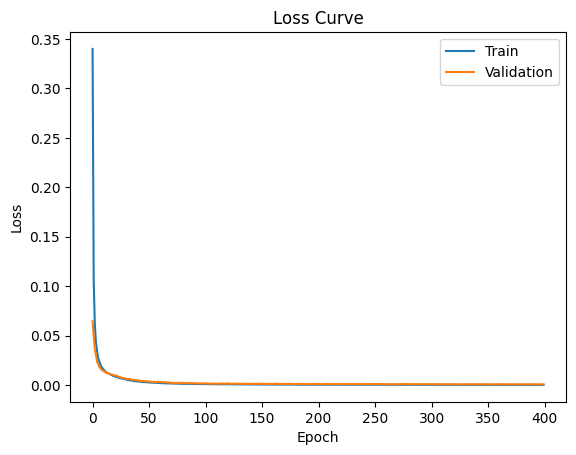

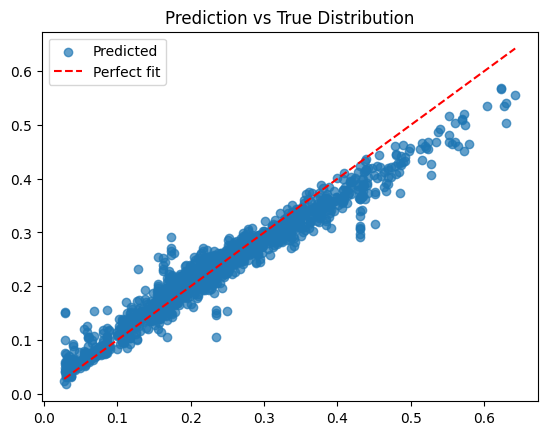

In [42]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [43]:
data= "Augmented Data"
encoding_method= 'One Hot Encoding'
feature_engineering= "With Feature Engineering"
run_id = 4
model_type = "CNN"
hyperparameters = {
    "epochs": 200,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


In [44]:
def mc_confidence(model, X_seq, X_num, n_iter=30):
    predictions = []

    for _ in range(n_iter):
        prediction = model([X_seq, X_num], training=True).numpy()
        predictions.append(prediction)

    predictions = np.array(predictions)
    mean = predictions.mean(axis=0)
    std = predictions.std(axis=0)
    return mean, std

In [45]:
mean, std = mc_confidence(model, X_seq_test, X_num_test, n_iter=30)

print("Mean Prediction:", mean[:10].squeeze())
print("Confidence (± std):", std[:10].squeeze())

Mean Prediction: [0.27539784 0.20922682 0.23306163 0.16807185 0.39958918 0.1454085
 0.27583945 0.17739981 0.12040643 0.4278215 ]
Confidence (± std): [0.01029714 0.01145707 0.00799282 0.01266862 0.01786337 0.00982368
 0.00668321 0.01356721 0.01035214 0.01455023]
